# Détection de fraudes bancaires avec Machine Learning
Ce projet vise à détecter les transactions frauduleuses en utilisant deux modèles de machine learning à partir du dataset Kaggle "Credit Card Fraud Detection". \
Objectif : maximiser la détection des fraudes tout en limitant les fausses alertes.

## Préparation des données


### Importation et aperçu du dataset
Les bibliothèques nécessaires sont importées (pandas, numpy, scikit-learn, matplotlib, seaborn).  
Le dataset *Credit Card Fraud Detection* est ensuite chargé et analysé.


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv("data/creditcard.csv")

print(df.shape)
print(df.head(2))

fraud_percentage = df['Class'].value_counts(normalize=True)[1] * 100
print(f"Pourcentage de fraudes : {fraud_percentage:.4f}%")

Le dataset contient 284 807 transactions et 31 variables :
- 28 variables issues d’une transformation PCA (V1 à V28),
- la variable `Amount`,
- la variable `Time`,
- la variable cible `Class` (0 = normal, 1 = fraude).

L’analyse initiale confirme un fort déséquilibre des classes, avec une proportion très faible de transactions frauduleuses (~0.17%).


### Séparation train / test et normalisation

Les données sont séparées en ensembles d’entraînement et de test en utilisant une séparation stratifiée afin de conserver la proportion de fraudes dans chaque ensemble.

La variable `Amount` est normalisée afin d’assurer une mise à l’échelle cohérente des variables.  
Cela permet d’éviter qu’une variable avec une grande amplitude influence excessivement le modèle, notamment pour la régression logistique.


In [ ]:

# Séparer les variables explicatives et la cible
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()

# On normalise le train et le test
X_train["Amount"] = scaler.fit_transform(X_train[["Amount"]])

X_test["Amount"] = scaler.transform(X_test[["Amount"]])

# On vérifie que la normalisation a bien fonctionnée
print(X_test["Amount"].describe())


## Premier modèle : regression logistique



### Entraînement du modèle

In [19]:

model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

### Évaluation avec un seuil initial

Un seuil de décision de 0.3 est d’abord testé afin d’observer les métriques principales (precision, recall, f1-score). \
Ce seuil arbitraire ne permet pas d’optimiser le compromis entre détection des fraudes et limitation des fausses alertes.

In [20]:

y_proba = model.predict_proba(X_test)[:, 1]

seuil = 0.3
y_pred = (y_proba >= seuil).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.70      0.72        98

    accuracy                           1.00     56962
   macro avg       0.87      0.85      0.86     56962
weighted avg       1.00      1.00      1.00     56962



### Optimisation du seuil

La courbe Precision-Recall est utilisée pour analyser la performance du modèle selon différents seuils.

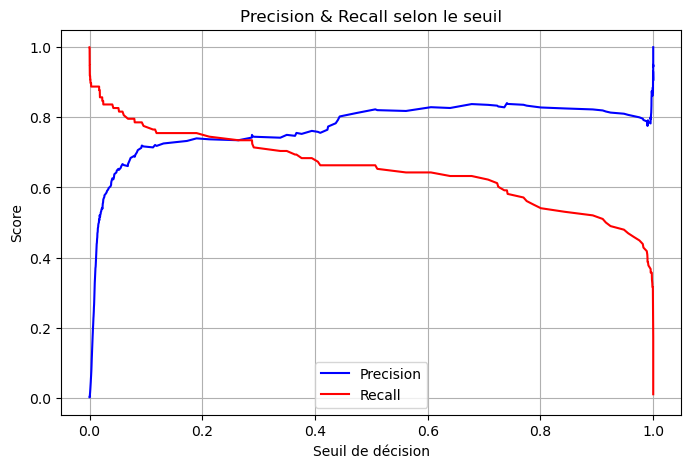

In [22]:

precisions, recalls, seuil = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8,5))
plt.plot(seuil, precisions[:-1], label='Precision', color='blue')
plt.plot(seuil, recalls[:-1], label='Recall', color='red')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.title('Precision & Recall selon le seuil')
plt.legend()
plt.grid(True)
plt.show()

Maximisation du nombre de recall et du f1-score en trouvant le seuil optimal par le calcul.


In [28]:

f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])

best_idx = f1_scores.argmax()       # index du meilleur f1
best_seuil = seuil[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Seuil optimal : {best_seuil:.3f} avec f1-score = {best_f1:.3f}\n")

# Affichage pour vérifier les métriques avec le seuil obtenu
y_pred_best = (y_proba >= best_seuil).astype(int)
print(classification_report(y_test, y_pred_best))

# Affichage AUC
print("AUC :", roc_auc_score(y_test, y_proba))

Seuil optimal : 0.093 avec f1-score = 0.751

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.79      0.75        98

    accuracy                           1.00     56962
   macro avg       0.86      0.89      0.88     56962
weighted avg       1.00      1.00      1.00     56962

AUC : 0.9557756135656288



Le modèle obtient :
- AUC ≈ 0.955
- f1-score ≈ 0.75

Bien que la capacité de séparation soit bonne (AUC élevé), la performance en détection de fraude reste perfectible. La capacité de séparation élevée peut être biaisée par le dataset qui ne contient que peu de fraudes.

### Analyse des coefficients

L’étude des coefficients du modèle montre que certaines composantes PCA, notamment V4, contribuent fortement à la discrimination entre transactions normales et frauduleuses.

Cependant, ces variables étant issues d’une transformation PCA, leur interprétation métier directe reste limitée.


In [ ]:

coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_[0]
})

coefficients = coefficients.sort_values(by="Coefficient", ascending=False)
print(coefficients.head(10))

   Feature  Coefficient
4       V4     0.761890
22     V22     0.660199
21     V21     0.402469
26     V26     0.207072
12     V12     0.188864
29  Amount     0.155404
5       V5     0.135630
1       V1     0.085970
24     V24     0.018801
18     V18     0.018161


### Matrice de confusion

La matrice de confusion permet d’observer le nombre exact de :
- fraudes détectées (True Positives),
- fraudes non détectées (False Negatives),
- fausses alertes (False Positives).

Elle met en évidence les limites du modèle linéaire, notamment dans la capacité à maximiser simultanément precision et recall.

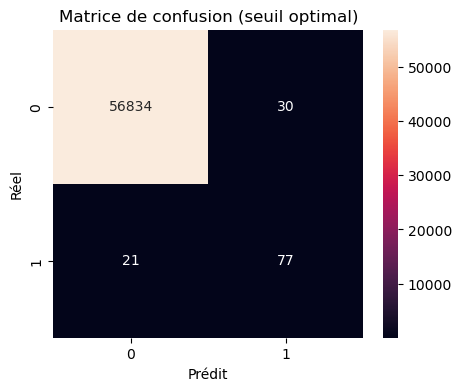

In [ ]:

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()

### Deuxième modèle : RandomForest


### Entraînement du modèle

Un RandomForestClassifier est entraîné avec pondération des classes afin de mieux gérer le déséquilibre.

Contrairement à la régression logistique, ce modèle est capable de capturer des relations non linéaires et des interactions entre variables.

In [ ]:

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

Visualisation des métriques avec un seuil test de 0.3.

In [36]:

y_proba_rf = rf.predict_proba(X_test)[:, 1]

seuil = 0.3
y_pred_rf = (y_proba_rf >= seuil).astype(int)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.84      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962



Avec une seuil de 0.3 on obtient déjà des performances supérieures à la regression logistique avec un f1-score de 0.88 et un recall de 0.84.

### Optimisation du seuil

Comme pour le modèle précédent, la courbe Precision-Recall est utilisée pour déterminer le seuil optimal maximisant le F1-score.



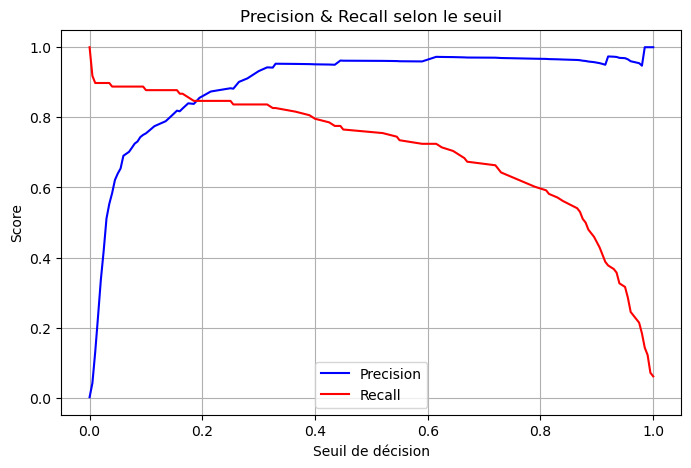

In [ ]:

precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(8,5))
plt.plot(thresholds_rf, precisions_rf[:-1], label='Precision', color='blue')
plt.plot(thresholds_rf, recalls_rf[:-1], label='Recall', color='red')
plt.xlabel('Seuil de décision')
plt.ylabel('Score')
plt.title('Precision & Recall selon le seuil')
plt.legend()
plt.grid(True)
plt.show()

In [44]:

f1_scores_rf = 2 * (precisions_rf[:-1] * recalls_rf[:-1]) / (precisions_rf[:-1] + recalls_rf[:-1])

best_idx_rf = f1_scores_rf.argmax()
best_threshold_rf = thresholds_rf[best_idx_rf]

print(f"Seuil optimal RF : {best_threshold_rf} avec f1-score = {f1_scores_rf[best_idx_rf]}\n")

y_pred_best_rf = (y_proba_rf >= best_threshold_rf).astype(int)
print(classification_report(y_test, y_pred_best_rf))

print("AUC :", roc_auc_score(y_test, y_proba_rf))

Seuil optimal RF : 0.315 avec f1-score = 0.8864864864864864

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.84      0.89        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

AUC : 0.9571890288895525



Résultats obtenus :
- AUC ≈ 0.957
- F1-score ≈ 0.89
- Precision ≈ 0.94
- Recall ≈ 0.84

### Matrice de confusion

La matrice de confusion montre une réduction significative du nombre de fraudes non détectées par rapport au modèle linéaire.

Le compromis entre recall et precision est nettement amélioré, ce qui rend ce modèle plus adapté à une application réelle de détection de fraude.

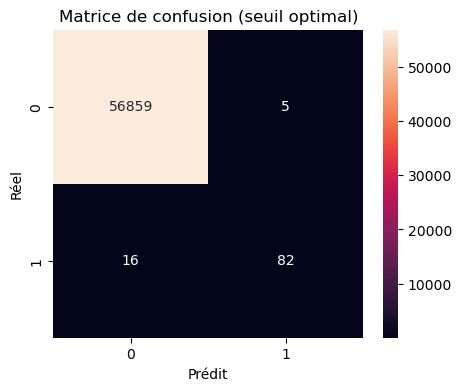

In [45]:
cm = confusion_matrix(y_test, y_pred_best_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion (seuil optimal)")
plt.show()

## Conclusion

Bien que les deux modèles présentent une AUC similaire (~0.96), le RandomForest améliore significativement le F1-score (0.89 contre 0.75 pour la régression logistique).

Cela indique que la séparation entre transactions normales et frauduleuses n’est pas strictement linéaire.

Le RandomForest est donc retenu comme modèle final, offrant un meilleur compromis entre détection des fraudes et limitation des fausses alertes.
